# Median and MAD based sample and feature selection

The data contains three biological replicates per timepoint. Ideally, these replicates have very similar feature values as they have received an identical treatment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
from ehv import load

In [4]:
df = load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))
df = load.remove_unwanted_features(df)
df = load.tag_columns(df)
df = load.clean_column_names(df)

In [55]:
df = df.filter(regex="(m0[1,4,6,7,11])|(ch0?[1,4,6,7,11])|meta")

In [5]:
df = df[df["meta_label_coi"]]

In [6]:
df.head()

,meta_object_number,feat_area_m01,feat_area_m03,feat_area_m04,feat_area_m06,feat_area_m07,feat_area_m09,feat_area_m11,feat_area_mc,feat_aspect_ratio_m01,...,feat_intensity_m02_ch02,feat_similarity_m01_ch02_ch03,meta_timepoint,meta_replicate,meta_group,meta_label_coi,meta_label_mcp_neg_psba_pos,meta_label_mcp_pos_psba_pos,meta_label_mcp_pos_psba_neg,meta_label_mcp_neg_psba_neg
6,6,38.333332,0.000000,0.0,12.000000,20.222221,40.777779,35.111111,51.111111,0.426284,...,0.000000,0.879332,0,R1,Ctrl,True,True,False,False,False
15,15,24.333334,0.000000,0.0,24.333334,19.222221,29.111111,34.222221,42.333332,0.919688,...,0.000000,1.001929,0,R1,Ctrl,True,True,False,False,False
16,16,33.111111,3.666667,0.0,11.555555,23.555555,29.666666,19.222221,33.222221,0.944940,...,217.214279,1.373776,0,R1,Ctrl,True,True,False,False,False
18,18,28.111111,4.666667,0.0,9.444445,17.555555,24.222221,19.777779,29.666666,0.942328,...,256.833344,0.968074,0,R1,Ctrl,True,True,False,False,False
21,21,29.666666,0.000000,0.0,12.555555,20.111111,25.555555,23.444445,30.888889,0.928602,...,251.892853,1.232937,0,R1,Ctrl,True,True,False,False,False


## Median and MAD for comparing feature values

We use the median and median absolute deviation as robust measures for characterizing feature distributions.

In [7]:
# compute stats over all cells in a timepoint
tp_level_stats = df.groupby(["meta_group", "meta_timepoint"])[df.filter(regex="feat").columns].agg(["median", "mad"])

In [8]:
# compute median over all cells in a replicate
rep_level_stats = df.groupby(["meta_group", "meta_timepoint", "meta_replicate"])[df.filter(regex="feat").columns].agg("median")

In [9]:
# expand tp_level_stats such that it becomes compatible with rep_level_stats
expanded_tp_level_stats = pandas.DataFrame(index=rep_level_stats.index, columns=tp_level_stats.columns)
for idx, row in tp_level_stats.iterrows():
    expanded_tp_level_stats.loc[(idx[0], idx[1])] = numpy.repeat(row.to_frame().T.values, len(expanded_tp_level_stats.loc[(idx[0], idx[1])]), axis=0)
expanded_tp_level_stats

feat_area_m01             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                 30.444445   8.052081   
                          R2                 30.444445   8.052081   
                          R3                 30.444445   8.052081   
           3              R1                 36.888889  33.838028   
                          R2                 36.888889  33.838028   
...                                                ...        ...   
Low        15             R2                 40.777779  17.379843   
                          R3                 40.777779  17.379843   
           16             R1                 43.888889  16.520927   
                          R2                 43.888889  16.520927   
                          R3                 43.888889  16.520927   

                                         feat_area_m03            \
                                                median       mad   
meta_group meta_timepoint meta_replicate                           
Ctrl       0              R1                       0.0  3.465379   
                          R2                       0.0  3.465379   
                          R3                       0.0  3.465379   
           3              R1                  7.444445  4.005329   
                          R2                  7.444445  4.005329   
...                                                ...       ...   
Low        15             R2                 11.111111  8.478171   
                          R3                 11.111111  8.478171   
           16             R1                 10.222222  9.346665   
                          R2                 10.222222  9.346665   
                          R3                 10.222222  9.346665   

                                         feat_area_m04             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                       0.0   0.170785   
                          R2                       0.0   0.170785   
                          R3                       0.0   0.170785   
           3              R1                       0.0   0.059566   
                          R2                       0.0   0.059566   
...                                                ...        ...   
Low        15             R2                 17.444445  12.482642   
                          R3                 17.444445  12.482642   
           16             R1                 10.222222  11.815638   
                          R2                 10.222222  11.815638   
                          R3                 10.222222  11.815638   

                                         feat_area_m06             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                 17.555555   6.711981   
                          R2                 17.555555   6.711981   
                          R3                 17.555555   6.711981   
           3              R1                 19.111111  12.759172   
                          R2                 19.111111  12.759172   
...                                                ...        ...   
Low        15             R2                 24.666666  10.368266   
                          R3                 24.666666  10.368266   
           16             R1                 27.666666   10.99062   
                          R2                 27.666666   10.99062   
                          R3                 27.666666   10.99062   

                                         feat_area_m07             ...  \
                                                median        mad  ...   
meta_group meta_timepoint meta_replicat

# Finding replicate level features with deviating values in Ctrl samples

For the Ctrl samples distributions for all features should be similar throughout the timepoints.

In [10]:
group_level_stats = df.groupby("meta_group")[df.filter(regex="feat").columns].agg(["median", "mad"])

In [16]:
# expand tp_level_stats such that it becomes compatible with rep_level_stats
expanded_group_level_stats = pandas.DataFrame(index=rep_level_stats.index, columns=group_level_stats.columns)
for idx, row in group_level_stats.iterrows():
    expanded_group_level_stats.loc[idx] = numpy.repeat(row.to_frame().T.values, len(expanded_group_level_stats.loc[idx]), axis=0)
expanded_group_level_stats

feat_area_m01             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                 34.777779  17.262218   
                          R2                 34.777779  17.262218   
                          R3                 34.777779  17.262218   
           3              R1                 34.777779  17.262218   
                          R2                 34.777779  17.262218   
...                                                ...        ...   
Low        15             R2                 37.888889  15.399297   
                          R3                 37.888889  15.399297   
           16             R1                 37.888889  15.399297   
                          R2                 37.888889  15.399297   
                          R3                 37.888889  15.399297   

                                         feat_area_m03             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                  3.888889   5.842399   
                          R2                  3.888889   5.842399   
                          R3                  3.888889   5.842399   
           3              R1                  3.888889   5.842399   
                          R2                  3.888889   5.842399   
...                                                ...        ...   
Low        15             R2                 11.111111  10.000422   
                          R3                 11.111111  10.000422   
           16             R1                 11.111111  10.000422   
                          R2                 11.111111  10.000422   
                          R3                 11.111111  10.000422   

                                         feat_area_m04             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                       0.0   0.154185   
                          R2                       0.0   0.154185   
                          R3                       0.0   0.154185   
           3              R1                       0.0   0.154185   
                          R2                       0.0   0.154185   
...                                                ...        ...   
Low        15             R2                       0.0  14.494809   
                          R3                       0.0  14.494809   
           16             R1                       0.0  14.494809   
                          R2                       0.0  14.494809   
                          R3                       0.0  14.494809   

                                         feat_area_m06             \
                                                median        mad   
meta_group meta_timepoint meta_replicate                            
Ctrl       0              R1                 19.666666  10.047192   
                          R2                 19.666666  10.047192   
                          R3                 19.666666  10.047192   
           3              R1                 19.666666  10.047192   
                          R2                 19.666666  10.047192   
...                                                ...        ...   
Low        15             R2                      22.0  10.217746   
                          R3                      22.0  10.217746   
           16             R1                      22.0  10.217746   
                          R2                      22.0  10.217746   
                          R3                      22.0  10.217746   

                                         feat_area_m07             ...  \
                                                median        mad  ...   
meta_group meta_timepoint

In [17]:
ctrl_outlier_features = pandas.DataFrame(index=rep_level_stats.index)
for col in df.filter(regex="feat"):
    left = expanded_group_level_stats[col]["median"] - expanded_group_level_stats[col]["mad"]
    right = expanded_group_level_stats[col]["median"] + expanded_group_level_stats[col]["mad"]
    ctrl_outlier_features[col] = ~rep_level_stats[col].between(left, right, inclusive=True)

In [101]:
ctrl_outlier_features.loc["Ctrl"].sum().sort_values(ascending=False)[:10]

feat_mean_pixel_m03_ch03                10
feat_modulation_m03_ch03                10
feat_gradient_rms_m03_ch03              10
feat_median_pixel_m03_ch03              10
feat_contrast_m03_ch03                  10
feat_width_m03                          10
feat_aspect_ratio_intensity_m03_ch03     9
feat_aspect_ratio_m03                    8
feat_max_pixel_mc_ch7                    6
feat_max_pixel_mc_ch03                   6
dtype: int64

### Many problems with auto-fluorescence (ch03)

In [103]:
ctrl_outlier_features.loc["Ctrl", df.filter(regex="(m|ch)0?3").columns].sum().sort_values()

feat_length_m03                             0
feat_height_m03                             0
feat_area_m03                               1
feat_bright_detail_intensity_r3_mc_ch03     1
feat_intensity_mc_ch03                      2
feat_similarity_m01_ch02_ch03               3
feat_max_pixel_mc_ch03                      6
feat_aspect_ratio_m03                       8
feat_aspect_ratio_intensity_m03_ch03        9
feat_modulation_m03_ch03                   10
feat_contrast_m03_ch03                     10
feat_gradient_rms_m03_ch03                 10
feat_mean_pixel_m03_ch03                   10
feat_median_pixel_m03_ch03                 10
feat_width_m03                             10
dtype: int64

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_length_m03'>

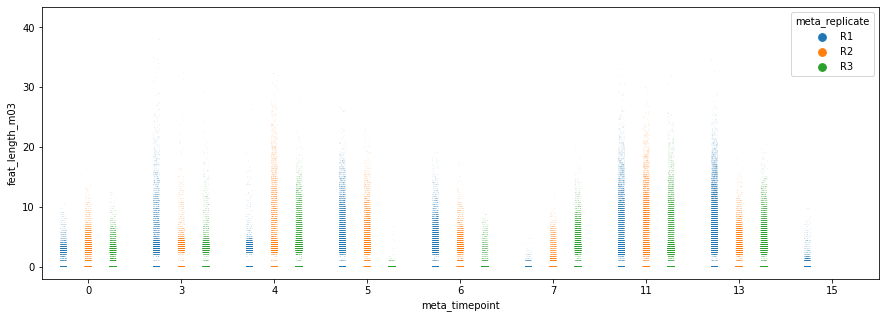

In [104]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Ctrl"], y="feat_length_m03", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_mean_pixel_m03_ch03'>

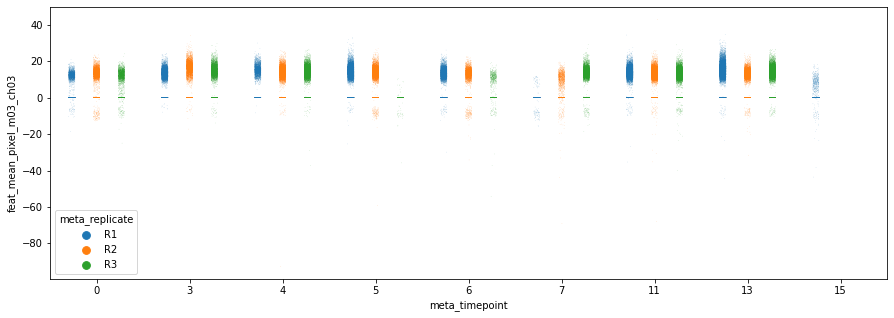

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Ctrl"], y="feat_mean_pixel_m03_ch03", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

In [112]:
df["meta_af"] = 0
df.loc[df["feat_mean_pixel_m03_ch03"] < 0, "meta_af"] = -1
df.loc[df["feat_mean_pixel_m03_ch03"] > 0, "meta_af"] = 1
df_ctrl = df[df["meta_group"] == "Ctrl"].copy()

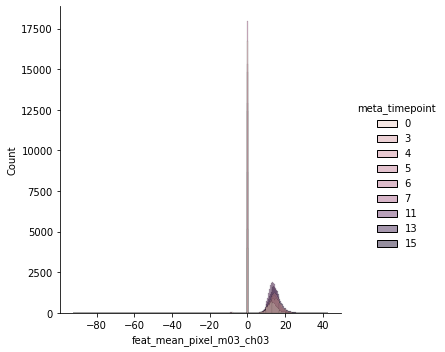

In [33]:
seaborn.displot(data=df_ctrl, x="feat_mean_pixel_m03_ch03", hue="meta_timepoint")

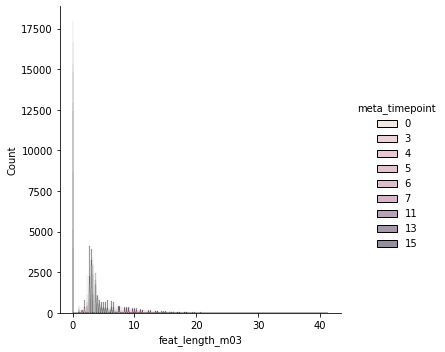

In [105]:
seaborn.displot(data=df_ctrl, x="feat_length_m03", hue="meta_timepoint")

<AxesSubplot:xlabel='meta_timepoint', ylabel='count'>

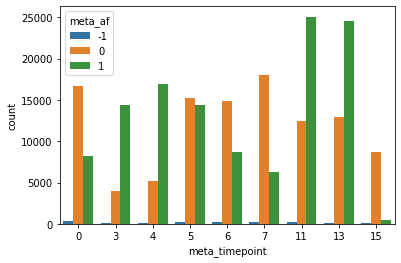

In [82]:
seaborn.countplot(data=df_ctrl, x="meta_timepoint", hue="meta_af")

In [84]:
from scipy.spatial.distance import jensenshannon

def to_prob(vec1, vec2):
    histP = numpy.histogram(vec1, bins=1000)
    P = histP[0]/histP[0].sum()
    histQ = numpy.histogram(vec2, bins=histP[1])
    Q = histQ[0]/histQ[0].sum()
    
    return P, Q 

X = df[df["meta_group"] == 'Ctrl'].filter(regex="feat").drop(columns=df.filter(regex="(m|ch)0?3").columns)
js = []
for col in X:
    x1 = df.loc[df["meta_af"] == 0, col]
    x2 = df.loc[df["meta_af"] == 1, col]
    P, Q = to_prob(x1, x2)
    js.append(jensenshannon(P, Q))

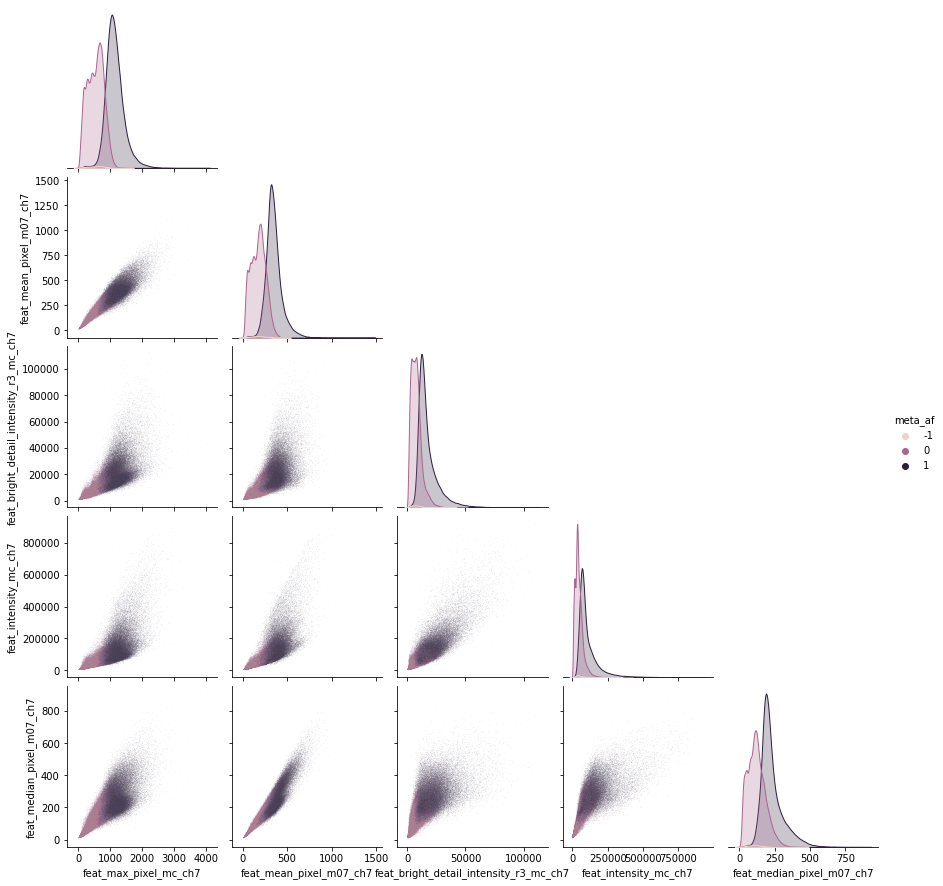

In [93]:
seaborn.pairplot(
    data=df_ctrl, hue="meta_af", 
    plot_kws=dict(s=0.1, alpha=0.5, edgecolors="none"),
    vars = X.columns[numpy.argsort(js)][::-1][:5], corner=True
)

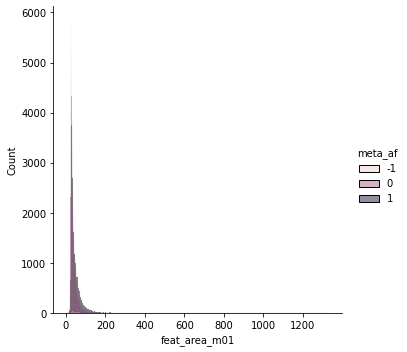

In [94]:
seaborn.displot(data=df_ctrl, x="feat_area_m01", hue="meta_af")

**In conclusion** we cannot explain the high number of cells with no signal in the auto-fluorescence channel. We should drop the features.

In [108]:
ctrl_outlier_features = ctrl_outlier_features.drop(columns=df.filter(regex="(m|ch)0?3").columns)

In [109]:
ctrl_outlier_features.loc["Ctrl"].sum().sort_values(ascending=False)[:10]

feat_max_pixel_mc_ch7                     6
feat_mean_pixel_m11_ch11                  5
feat_median_pixel_m07_ch7                 5
feat_mean_pixel_m07_ch7                   5
feat_max_pixel_mc_ch11                    4
feat_median_pixel_m11_ch11                4
feat_max_pixel_m02_ch02                   4
feat_intensity_mc_ch04                    3
feat_bright_detail_intensity_r3_mc_ch7    3
feat_mean_pixel_m09_bf2                   3
dtype: int64

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_max_pixel_mc_ch7'>

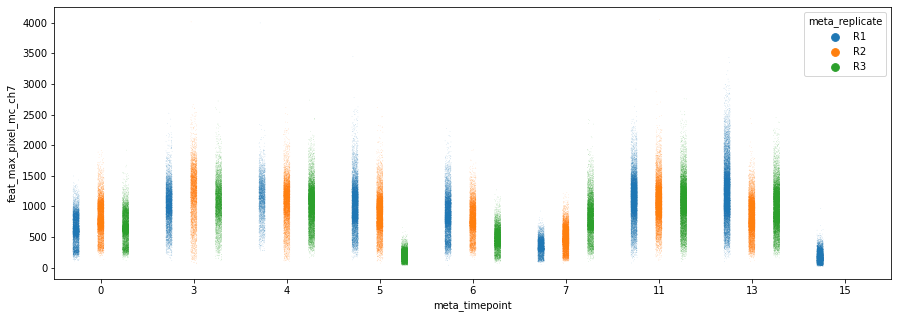

In [110]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df_ctrl, y="feat_max_pixel_mc_ch7", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_mean_pixel_m11_ch11'>

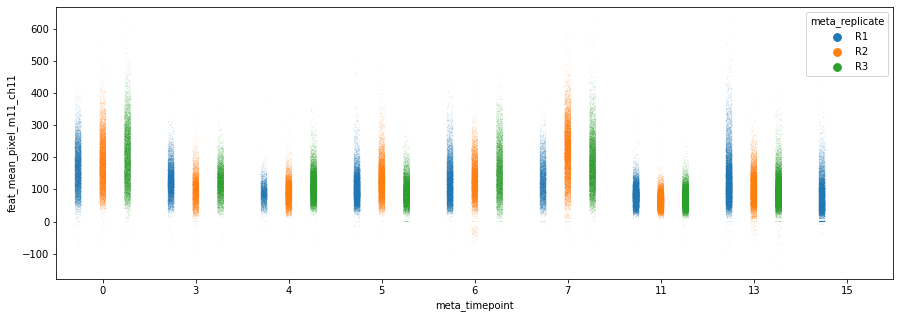

In [111]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df_ctrl, y="feat_mean_pixel_m11_ch11", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

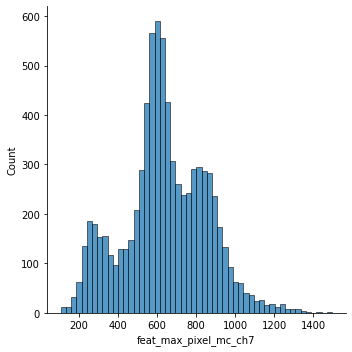

In [126]:
seaborn.displot(data=df_ctrl[(df_ctrl["meta_timepoint"] == 0) & (df_ctrl["meta_replicate"]=="R1")], x="feat_max_pixel_mc_ch7")

In [127]:
df_ctrl[(df_ctrl["meta_timepoint"] == 0) & (df_ctrl["meta_replicate"]=="R1")]["feat_max_pixel_mc_ch7"].value_counts()

665.031250    2
609.060608    2
654.324219    2
556.159119    2
663.996216    2
             ..
602.970947    1
626.878296    1
714.018921    1
576.194824    1
207.237808    1
Name: feat_max_pixel_mc_ch7, Length: 7766, dtype: int64

In [130]:
counts, bins = numpy.histogram(df_ctrl[(df_ctrl["meta_timepoint"] == 0) & (df_ctrl["meta_replicate"]=="R1")]["feat_max_pixel_mc_ch7"], bins=1000)

In [134]:
bins[numpy.argmax(counts)]

588.71423

In [124]:
scipy.stats.mode(df_ctrl[(df_ctrl["meta_timepoint"] == 0) & (df_ctrl["meta_replicate"]=="R1")]["feat_max_pixel_mc_ch7"])

ModeResult(mode=array([242.03041], dtype=float32), count=array([2]))

In [136]:
def mode_center(df, col):
    counts, bins = numpy.histogram(df[col], bins=1000)
    df[col+"_mode_centered"] = df[col] - bins[numpy.argmax(counts)]
    return df

df_ctrl = df_ctrl.groupby(["meta_timepoint", "meta_replicate"]).apply(lambda df: mode_center(df, "feat_max_pixel_mc_ch7"))

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_max_pixel_mc_ch7_mode_centered'>

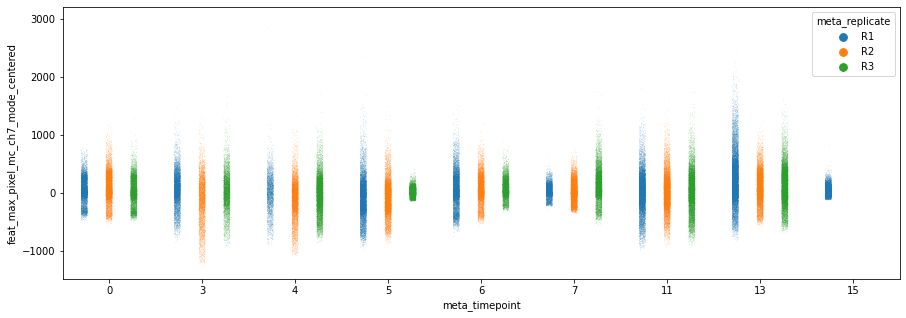

In [137]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df_ctrl, y="feat_max_pixel_mc_ch7_mode_centered", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

In [40]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.05, 0.95))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_robust_scale)

## Finding replicate level features with deviating values

We assume that features of replicates are equally distributed within a timepoint and thus we can identify abberant samples by comparing feature distributions of individual samples to the distributions of all samples combined within a timepoint. 

We identify features as outliers if the file level median value does not fall in the timepoint level [median - mad, median + mad] interval.

In [10]:
outlier_features = pandas.DataFrame(index=rep_level_stats.index)
for col in df.filter(regex="feat"):
    left = expanded_tp_level_stats[col]["median"] - expanded_tp_level_stats[col]["mad"]
    right = expanded_tp_level_stats[col]["median"] + expanded_tp_level_stats[col]["mad"]
    outlier_features[col] = ~rep_level_stats[col].between(left, right, inclusive=True)

### Looking at which samples deviate often

Counting the amount of outlier features identified for each sample, reveals the problematic samples.

In [13]:
outlier_features[outlier_features.any(axis=1)].sum(axis=1).sort_values(ascending=False)

meta_group  meta_timepoint  meta_replicate
High        16              R1                31
Low         14              R1                29
High        13              R2                26
Low         15              R1                25
High        13              R3                24
            16              R2                19
            12              R3                17
Low         14              R2                15
            0               R1                14
Ctrl        7               R3                14
Low         1               R1                13
            6               R3                12
            13              R1                12
Ctrl        5               R3                12
Low         0               R2                11
High        1               R1                11
            14              R1                11
Ctrl        5               R2                11
            6               R1                11
            5             

This list shows the samples which have the highest number of deviating features. For example, replicate 1 from timepoint 16 in group High has 31 flagged features. Note that as expected the samples with most outlier features are those of later timepoints.

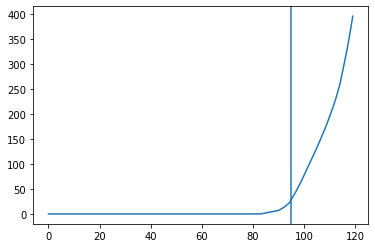

In [16]:
cutoff = 95
ax = outlier_features.sum(axis=1).sort_values().cumsum().reset_index()[0].plot()
ax.axvline(cutoff)

Looking at the above plot we can set the cutoff at 95, selecting the 95 files which have the least deviating features.

In [19]:
outlier_features.sum(axis=1).sort_values()[cutoff:]

meta_group  meta_timepoint  meta_replicate
Low         6               R1                 8
High        15              R1                 9
Low         16              R1                 9
High        15              R2                10
Ctrl        13              R2                10
Low         0               R2                11
Ctrl        5               R1                11
            6               R1                11
            5               R2                11
High        1               R1                11
            14              R1                11
Ctrl        5               R3                12
Low         6               R3                12
            13              R1                12
            1               R1                13
            0               R1                14
Ctrl        7               R3                14
Low         14              R2                15
High        12              R3                17
            16            

In [25]:
selected_samples = outlier_features.sum(axis=1).sort_values()[:cutoff].index

In [18]:
selected_samples.to_frame().to_csv("data/selected_samples.csv", index=False)

### Looking at which features deviate often

After selecting problematic samples, we can also look at features that stand out in the remaining samples and drop them if necessary.

In [11]:
selected_samples = "Low"

In [12]:
outlier_features_filtered = outlier_features.loc[selected_samples]

In [20]:
outlier_features_filtered[outlier_features_filtered.any(axis=1)].sum(axis=0).sort_values(ascending=False)[:20]

feat_max_pixel_mc_ch7                     9
feat_width_m03                            7
feat_aspect_ratio_m03                     7
feat_mean_pixel_m03_ch03                  7
feat_height_m03                           6
feat_gradient_rms_m03_ch03                6
feat_length_m03                           6
feat_modulation_m03_ch03                  6
feat_median_pixel_m03_ch03                6
feat_mean_pixel_m07_ch7                   6
feat_aspect_ratio_intensity_m03_ch03      6
feat_bright_detail_intensity_r3_mc_ch7    5
feat_intensity_m02_ch02                   5
feat_max_pixel_mc_ch03                    5
feat_intensity_mc_ch03                    5
feat_area_m03                             5
feat_intensity_mc_ch7                     4
feat_median_pixel_m07_ch7                 4
feat_max_pixel_m02_ch02                   4
feat_intensity_mc_bf2                     3
dtype: int64

In [24]:
outlier_features_filtered

feat_area_m01  feat_area_m03  feat_area_m04  \
meta_timepoint meta_replicate                                                
0              R1                      False           True          False   
               R2                      False           True          False   
               R3                      False          False          False   
1              R1                      False           True          False   
               R2                      False          False          False   
               R3                      False          False          False   
2              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
3              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
4              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
5              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
6              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
7              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
8              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
9              R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
11             R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
12             R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
13             R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   
14             R1                      False           True          False   
               R2                      False          False           True   
               R3                      False          False          False   
15             R1                      False           True          False   
               R2                      False          False          False   
               R3                      False          False          False   
16             R1                      False          False          False   
               R2                      False          False          False   
               R3                      False          False          False   

                               feat_area_m06  feat_area_m07  feat_area_m09  \
meta_timepoint meta_replicate                       

In [31]:
flagged_files = []
for col in outlier_features_filtered.columns[outlier_features_filtered[outlier_features_filtered.any(axis=1)].sum(axis=0) > 0]:
    flagged_files.append(outlier_features_filtered[outlier_features_filtered[col]].index.to_frame().reset_index(drop=True))

In [37]:
pandas.concat(flagged_files, axis=0).value_counts()

meta_timepoint  meta_replicate
14              R1                29
15              R1                25
14              R2                15
0               R1                14
1               R1                13
6               R3                12
13              R1                12
0               R2                11
16              R1                 9
6               R1                 8
1               R3                 4
3               R1                 1
4               R1                 1
11              R1                 1
12              R1                 1
dtype: int64

In [89]:
outlier_features_filtered[outlier_features_filtered["feat_max_pixel_mc_ch7"]]

feat_area_m01  feat_area_m03  feat_area_m04  \
meta_timepoint meta_replicate                                                
0              R1                      False           True          False   
1              R1                      False           True          False   
               R3                      False          False          False   
6              R1                      False          False          False   
11             R1                      False          False          False   
12             R1                      False          False          False   
13             R1                      False          False          False   
14             R1                      False           True          False   
15             R1                      False           True          False   

                               feat_area_m06  feat_area_m07  feat_area_m09  \
meta_timepoint meta_replicate                                                
0              R1                      False          False          False   
1              R1                      False          False          False   
               R3                      False          False          False   
6              R1                      False          False          False   
11             R1                      False          False          False   
12             R1                      False          False          False   
13             R1                      False          False          False   
14             R1                      False          False          False   
15             R1                      False          False          False   

                               feat_area_m11  feat_area_mc  \
meta_timepoint meta_replicate                                
0              R1                      False         False   
1              R1                      False         False   
               R3                      False         False   
6              R1                      False         False   
11             R1                      False         False   
12             R1                      False         False   
13             R1                      False         False   
14             R1                      False         False   
15             R1                      False         False   

                               feat_aspect_ratio_m01  feat_aspect_ratio_m03  \
meta_timepoint meta_replicate                                                 
0              R1                              False                   True   
1              R1                              False                   True   
               R3                              False                  False   
6              R1                              False                   True   
11             R1                              False                  False   
12             R1                              False                  False   
13             R1                              False                  False   
14             R1                              False                   True   
15             R1                              False                  False   

                               ...  feat_bright_detail_intensity_r3_mc_bf  \
meta_timepoint meta_replicate  ...                                          
0              R1              ...                                  False   
1              R1              ...                                  False   
               R3              ...                                  False   
6              R1              ...                                  False   
11             R1              ...                                  False   
12             R1              ...                                  False   
13             R1              ...                                  False   
14             R1              ...                                 

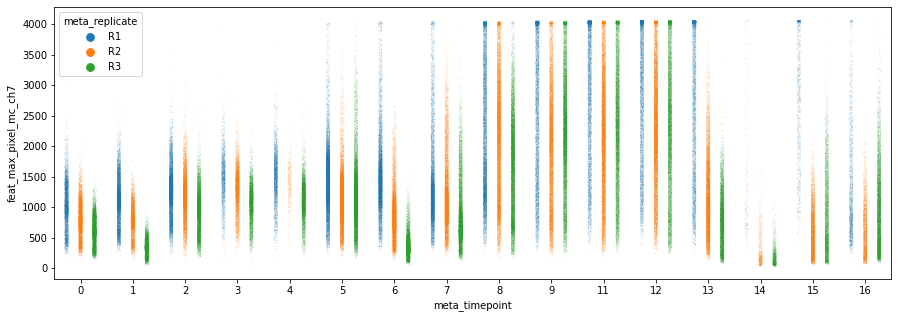

In [90]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Low"], y="feat_max_pixel_mc_ch7", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)
plt.savefig("figs/feat_max_pixel_mc_ch7.png")

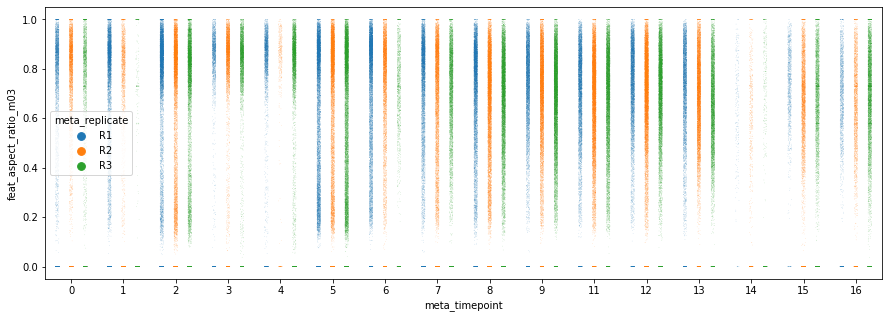

In [93]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Low"], y="feat_aspect_ratio_m03", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)
plt.savefig("figs/feat_aspect_ratio_m03.png")

In [66]:
outlier_features_filtered[outlier_features_filtered["feat_bright_detail_intensity_r3_mc_ch7"]]

,,feat_area_m01,feat_area_m04,feat_area_m06,feat_area_m07,feat_aspect_ratio_m01,feat_aspect_ratio_m04,feat_aspect_ratio_m06,feat_aspect_ratio_m07,feat_aspect_ratio_intensity_m01_bf,feat_aspect_ratio_intensity_m04_ch04,...,feat_width_m06,feat_width_m07,feat_height_m01,feat_height_m04,feat_height_m06,feat_height_m07,feat_bright_detail_intensity_r3_mc_ch04,feat_bright_detail_intensity_r3_mc_ch7,feat_bright_detail_intensity_r3_mc_ch11,feat_similarity_m01_ch02_ch03
meta_timepoint,meta_replicate,,,,,,,,,,,,,,,,,,,,,
6,R1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
13,R1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
14,R1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,True
15,R1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
16,R1,False,False,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False


<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_bright_detail_intensity_r3_mc_ch7'>

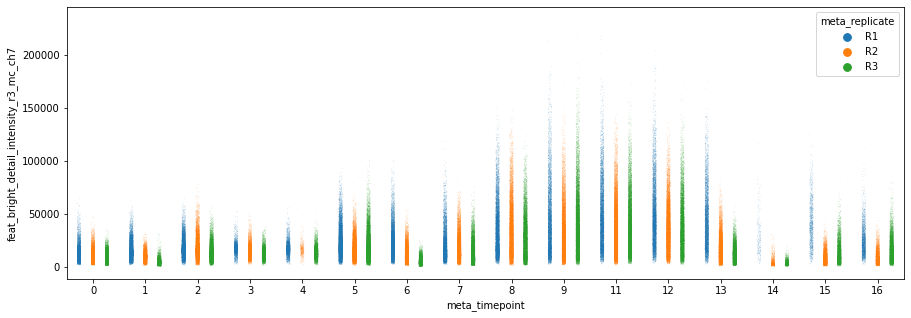

In [67]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Low"], y="feat_bright_detail_intensity_r3_mc_ch7", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

In [68]:
outlier_features_filtered[outlier_features_filtered.any(axis=1)].sum(axis=0).sort_values(ascending=False)[-20:]

feat_area_m06                           0
feat_aspect_ratio_intensity_m01_bf      0
feat_max_pixel_mc_ch04                  0
feat_gradient_rms_m01_bf                0
feat_contrast_m01_bf                    0
feat_contrast_m06_ssc                   0
feat_gradient_rms_m06_ssc               0
feat_gradient_rms_m07_ch7               0
feat_gradient_rms_m11_ch11              0
feat_intensity_mc_ch04                  0
feat_contrast_m04_ch04                  0
feat_modulation_m11_ch11                0
feat_aspect_ratio_intensity_m07_ch7     0
feat_mean_pixel_m04_ch04                0
feat_mean_pixel_m06_ssc                 0
feat_modulation_m01_bf                  0
feat_median_pixel_m04_ch04              0
feat_median_pixel_m06_ssc               0
feat_aspect_ratio_intensity_m11_ch11    0
feat_area_m01                           0
dtype: int64

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_mean_pixel_m04_ch04'>

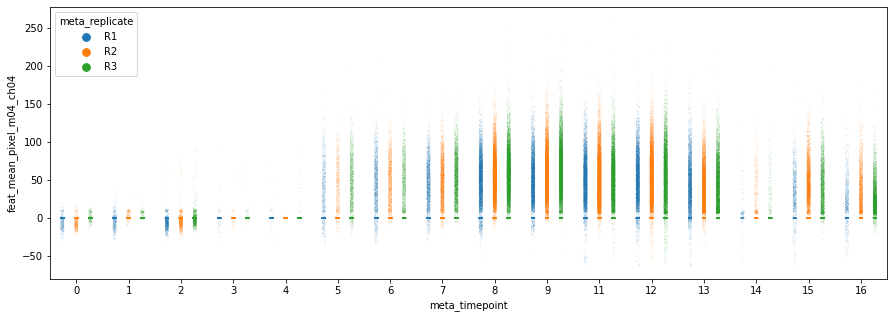

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Low"], y="feat_mean_pixel_m04_ch04", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)

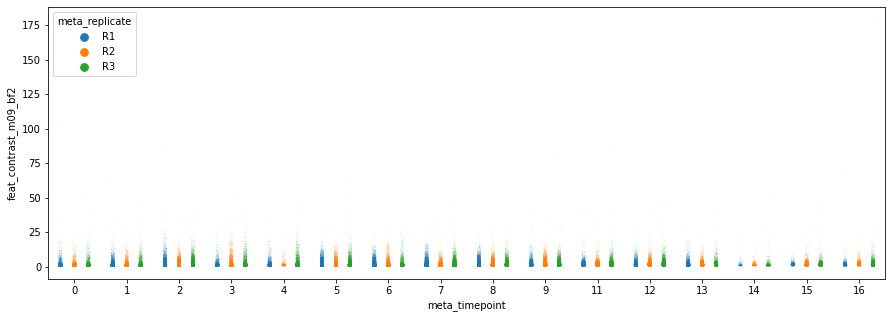

In [94]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Low"], y="feat_contrast_m09_bf2", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)
plt.savefig("figs/feat_contrast_m09_bf2.png")

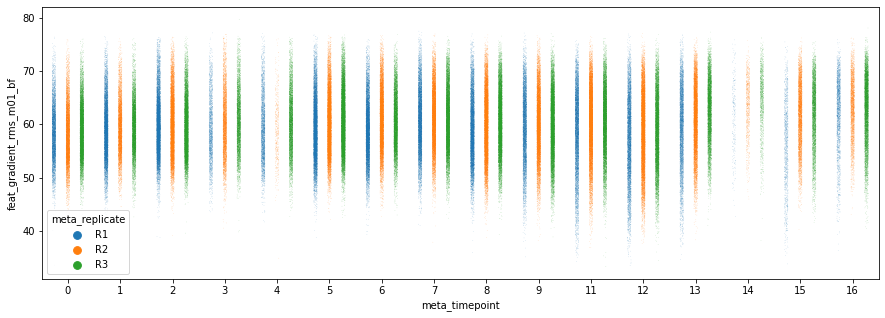

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
seaborn.stripplot(data=df[df["meta_group"] == "Low"], y="feat_gradient_rms_m01_bf", x="meta_timepoint", hue="meta_replicate", dodge=True, s=0.5, alpha=0.5, ax=ax)
plt.savefig("figs/feat_gradient_rms_m01_bf.png")

In [14]:
outlier_features_filtered.columns[~outlier_features_filtered.any(axis=0)].shape

(57,)

In [16]:
from kneed import KneeLocator

y = outlier_features_filtered.sum(axis=0).sort_values().cumsum().reset_index()[0].values
x = numpy.arange(len(y))
kneedle = KneeLocator(x, y, S=1.0, curve="convex", direction="increasing")

kneedle.elbow

67

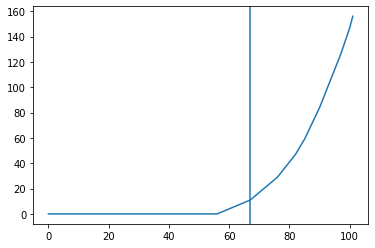

In [39]:
ax = outlier_features_filtered.sum(axis=0).sort_values().cumsum().reset_index()[0].plot()
ax.axvline(kneedle.elbow)
plt.savefig("figs/kneedle.png")

We choose to keep the 67 first features.

In [18]:
selected_features = outlier_features_filtered.sum(axis=0).sort_values()[:kneedle.elbow].index

In [19]:
outlier_features_filtered.sum(axis=0).sort_values()[kneedle.elbow:].index

Index(['feat_height_m11', 'feat_height_m04', 'feat_length_m04',
       'feat_bright_detail_intensity_r3_mc_ch11', 'feat_width_m04',
       'feat_mean_pixel_m01_bf', 'feat_gradient_rms_m09_bf2',
       'feat_aspect_ratio_m04', 'feat_modulation_m07_ch7',
       'feat_intensity_mc_bf', 'feat_aspect_ratio_intensity_m04_ch04',
       'feat_contrast_m03_ch03', 'feat_gradient_rms_m04_ch04',
       'feat_intensity_mc_bf2', 'feat_similarity_m01_ch02_ch03',
       'feat_mean_pixel_m09_bf2', 'feat_intensity_mc_ch7',
       'feat_max_pixel_m02_ch02', 'feat_median_pixel_m07_ch7',
       'feat_intensity_mc_ch03', 'feat_intensity_m02_ch02',
       'feat_max_pixel_mc_ch03', 'feat_bright_detail_intensity_r3_mc_ch7',
       'feat_area_m03', 'feat_median_pixel_m03_ch03', 'feat_height_m03',
       'feat_length_m03', 'feat_mean_pixel_m07_ch7',
       'feat_gradient_rms_m03_ch03', 'feat_modulation_m03_ch03',
       'feat_aspect_ratio_intensity_m03_ch03', 'feat_mean_pixel_m03_ch03',
       'feat_width_m03', 

In [40]:
with open("data/selected_features_low.txt", "w") as fh:
    fh.write(",".join(selected_features.values))